# Features

`BGLS` supports several useful features when simulating circuits, described below.

In [1]:
"""Setup."""
import cirq

import bgls

## Accessing final states

While measurement results (samples) are returned, final states are stored and can be accessed from `bgls.Simulator.final_states` as below.

In [2]:
a, b = cirq.LineQubit.range(2)

circuit = cirq.Circuit(
    cirq.H.on(a),
    cirq.CNOT.on(a, b),
    cirq.measure(a, b, key="z"),
)

sim = bgls.Simulator(
    initial_state=cirq.StateVectorSimulationState(
        qubits=(a, b), initial_state=0
    ),
    apply_op=cirq.protocols.act_on,
    compute_probability=bgls.born.compute_probability_state_vector,
)
results = sim.run(circuit, repetitions=10)
print("Results:", results)

final_state = sim.final_states[0]
print("Final state:", cirq.dirac_notation(final_state.target_tensor.flatten()))

Results: z=1111111100, 1111111100
Final state: 0.71|00⟩ + 0.71|11⟩


Note that here, although we sampled multiple times, there is only one final state.

In [3]:
len(sim.final_states)

1

This is because `BGLS` samples all bitstrings in parallel for unitary circuits. For circuits with non-unitary channels that are not terminal measurements (see below), the method of quantum trajectories is used and one bitstring is sampled per trajectory, leading to multiple final states.

Final state history can be reset as follows.

In [4]:
sim.clear_final_states()
sim.final_states

[]

## Simulating noisy circuits

If your `apply_op` function can apply channels, you can use `BGLS` to simulate noisy circuits through quantum trajectores. An example using `cirq.protocols.act_on`, which can apply channels, is shown below.

/home/ryan/prof/work/bgls/envbgls/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


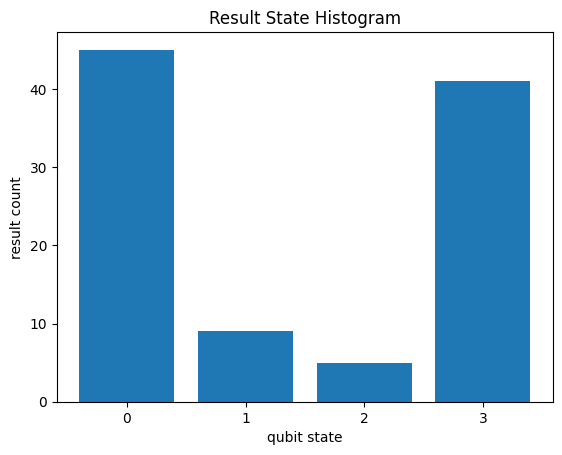

In [5]:
a, b = cirq.LineQubit.range(2)

circuit = cirq.Circuit(cirq.H.on(a), cirq.CNOT.on(a, b))
noisy = circuit.with_noise(cirq.depolarize(0.05))

sim = bgls.Simulator(
    initial_state=cirq.StateVectorSimulationState(
        qubits=(a, b), initial_state=0
    ),
    apply_op=cirq.protocols.act_on,
    compute_probability=bgls.born.compute_probability_state_vector,
)

results = sim.run(noisy + cirq.measure(a, b), repetitions=100)
cirq.plot_state_histogram(results);

### How to modify `apply_op` to support channels

You can modify your `apply_op` function to support channels as follows. The simplest case is when the probability of a Kraus operator does not depend on the state. In this case, you can use the `cirq.mixture` protocol to obtain `(probability, kraus_operator)` pairs as in the example below.

In [6]:
channel = cirq.DepolarizingChannel(p=0.01)

cirq.mixture(channel)

((0.99,
  array([[1., 0.],
         [0., 1.]])),
 (0.0033333333333333335,
  array([[0.+0.j, 1.+0.j],
         [1.+0.j, 0.+0.j]])),
 (0.0033333333333333335,
  array([[0.+0.j, 0.-1.j],
         [0.+1.j, 0.+0.j]])),
 (0.0033333333333333335,
  array([[ 1.+0.j,  0.+0.j],
         [ 0.+0.j, -1.+0.j]])))

Now, you just need to select a Kraus operator according to the probability distribution and then apply it to the state. 

If the channel does not support the `cirq.mixture` protocol (i.e., if the probability of applying a Kraus operator depends on the state $|\psi\rangle$), you can still use this method by first using `cirq.kraus` to obtain the Kraus operators $K_i$ of the channel, then computing the probability of applying each channel via $p_i = \langle \psi | K_i^\dagger K_i |\psi\rangle$. 

> Note: For noiseless simulation, `BGLS` updates all bitstrings in parallel via one evolution of the state. This isn't possible in quantum trajectories because many different states are generated, so you should expect noisy simulation to be slower.

## Simulating circuits with intermediate measurements

In the same manner described above, `BGLS` can simulate circuits with intermediate measurements if `apply_op` supports channels.

/home/ryan/prof/work/bgls/envbgls/lib/python3.10/site-packages/cirq/vis/state_histogram.py:103: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


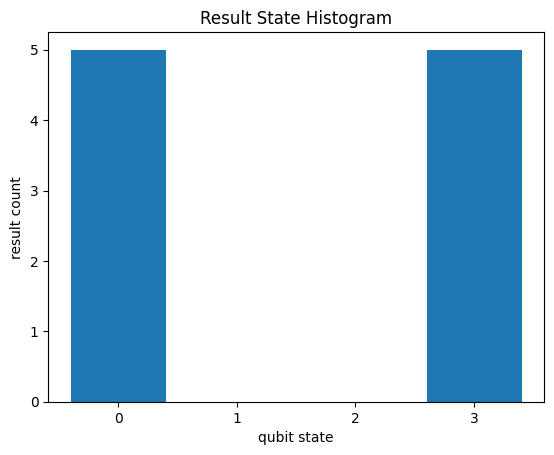

In [7]:
a, b = cirq.LineQubit.range(2)

circuit = cirq.Circuit(
    cirq.H.on(a),
    cirq.measure(a),  # <-- Intermediate measurement.
    cirq.CNOT.on(a, b),
    cirq.measure(a, b),
)

sim.clear_final_states()
results = sim.run(circuit, repetitions=10)
cirq.plot_state_histogram(results);

Here the final states are $|00\rangle$ or $|11\rangle$ with equal probability.

In [8]:
for final_state in sim.final_states:
    print(f"Final state:", cirq.dirac_notation(final_state.target_tensor.flatten()))

Final state: |11⟩
Final state: |00⟩
Final state: |11⟩
Final state: |11⟩
Final state: |00⟩
Final state: |11⟩
Final state: |00⟩
Final state: |00⟩
Final state: |00⟩
Final state: |11⟩


## Can I use `BGLS` with Qiskit / Pennylane / etc.?

The only accepted circuit type for `BGLS` is `cirq.Circuit`, but you can convert most popular circuit types to and from Cirq. For example, if you have a Qiskit circuit specified by the following Qasm string:

In [9]:
qasm = """
OPENQASM 2.0;
include "qelib1.inc";

qreg q[2];

h q[0];
cx q[0],q[1];"""

You can convert this to a Cirq circuit as follows.

In [10]:
from cirq.contrib.qasm_import import circuit_from_qasm

circuit_from_qasm(qasm)

q_0: ───H───@───
            │
q_1: ───────X───

This circuit can now be used with `BGLS`.